In [47]:
from rdkit import Chem
import numpy as np
import pandas as pd
from IPython.display import display
import tqdm

# Load simulator data

In [48]:
dataset = pd.read_csv("/home/abhor/Desktop/repos/ReactionRL/datasets/my_uspto/action_dataset.csv", index_col=0)

In [49]:
dataset

,reactants,products,rsig,psig,rsub,psub,rcen,pcen,rbond,pbond,rsig_clusters
0,CON(C)C(=O)c1ccc(O)nc1,CC(C)CC(=O)c1ccc(O)nc1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][CH:1]([CH3:2])[CH2:3][C:4](=[O:5])[c:6...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][CH:1]([CH3:2])[CH3:3],2,3,[[1.0]],[[1.0]],0
8174,CCc1nc(C(F)(F)F)ccc1C(=O)N(C)OC,CCc1nc(C(F)(F)F)ccc1C=O,[cH:0]1[n:1][cH:2][cH:3][cH:4][c:5]1[C:6](=[O:...,[H:0],[NH:8]([CH3:9])[O:10][CH3:11],[H:0],8,0,[[1.0]],[[1.0]],0
25624,CON(C)C(=O)c1ccc(Cl)nc1N,COc1cc(C)c(F)cc1C(=O)c1ccc(Cl)nc1N,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][O:1][c:2]1[cH:3][c:4]([CH3:5])[c:6]([F...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][O:1][c:2]1[cH:3][c:4]([CH3:5])[c:6]([F...,2,9,[[1.0]],[[1.0]],0
27114,CON(C)C(=O)c1cccnc1Cl,CC(=O)c1cccnc1Cl,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][C:1](=[O:2])[c:3]1[cH:4][cH:5][cH:6][n...,[CH3:0][O:1][NH:2][CH3:3],[CH4:0],2,0,[[1.0]],[[1.0]],0
68734,CON(C)C(=O)c1ccc(Cl)nc1,COc1ccccc1C(=O)c1ccc(Cl)nc1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][O:1][c:2]1[cH:3][cH:4][cH:5][cH:6][c:7...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][O:1][c:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1,2,7,[[1.0]],[[1.0]],0
...,...,...,...,...,...,...,...,...,...,...,...
448267,O=C1c2ccccc2C(=O)N1CCS(=O)(=O)Cl,CCN1C(=O)c2ccccc2C1=O,[CH3:0][CH2:1][S:2](=[O:3])(=[O:4])[Cl:5],[H:0],[SH:2](=[O:3])(=[O:4])[Cl:5],[H:0],2,0,[[1.0]],[[1.0]],394244
448392,CCNC(=O)n1nc(N)c2cc(C(F)(F)F)ccc21,CCN=C=O,[CH3:0][NH:1][C:2](=[O:3])[n:4]1[n:5][c:6]([NH...,[CH3:0][N:1]=[C:2]=[O:3],[CH:2](=[O:3])[n:4]1[n:5][c:6]([NH2:7])[c:8]2[...,[CH2:2]=[O:3],2,2,[[1.0]],[[2.0]],394333
448417,O=P(C(F)(F)C(F)(F)F)(C(F)(F)C(F)(F)F)C(F)(F)C(...,O=P([O-])(C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F,[O:0]=[P:1]([CH3:2])([CH3:3])[C:4]([F:5])([F:6...,[O:0]=[P:1]([O-:2])([CH3:3])[CH3:4],[CH:4]([F:5])([F:6])[C:7]([F:8])([F:9])[F:10],[O-:2],4,2,[[1.0]],[[1.0]],394354
448458,CCOc1ccc(C(C)(C)COCc2ccc(F)c(Oc3ccccc3)c2)cc1,CCOc1ccc(C(C)(C)CO)cc1,[CH3:0][O:1][CH2:2][c:3]1[cH:4][cH:5][c:6]([F:...,[H:0],[CH3:2][c:3]1[cH:4][cH:5][c:6]([F:7])[c:8]([O:...,[H:0],2,0,[[1.0]],[[1.0]],394383


# Indexing 

First, we create index for rsub to make for faster searching.

Searching will be based on rsub because the action searching algorithm cannot create rsigs. rsigs will be used for substructure matching.

In [50]:
import networkx as nx

In [51]:
# Fetch the rsigs using the clusters
rsig_cluster_to_rsig_d = {}
for cluster_id in dataset["rsig_clusters"].unique():
    cluster_df = dataset[dataset["rsig_clusters"] == cluster_id]
    rsig  = Chem.MolFromSmiles(cluster_df.iloc[0]["rsig"])
    rsig_cluster_to_rsig_d[cluster_id] = rsig
    
print(f"There are {len(rsig_cluster_to_rsig_d)} unique (rsigs)rsigs.")

There are 40325 unique (rsigs)rsigs.


# Get atom frequency for making rings in the signature
atom_frequency = {}

for i in tqdm.tqdm(range(dataset.shape[0]), total=dataset.shape[0]):
    atoms = list(Chem.MolFromSmiles(dataset.iloc[i]["reactants"]).GetAtoms()) + list(Chem.MolFromSmiles(dataset.iloc[i]["products"]).GetAtoms())
    atom_nums, counts = np.unique(list(map(lambda x: x.GetAtomicNum(), atoms)), return_counts=True)
    for num, cnt in zip(atom_nums, counts):
        if num not in atom_frequency:
            atom_frequency[num] = cnt
        else:
            atom_frequency[num] += cnt

mapping = list(range(1, 50))
mapping.remove(2)
atom_to_freq_order = {x: mapping[i] for i, (_, x) in enumerate(sorted(zip(list(atom_frequency.values()), list(atom_frequency.keys())))[::-1])}

import pynauty

# For each rsig, genearate a certificate
def get_mol_certificate(mol):
    adj_mat = Chem.GetAdjacencyMatrix(mol)

    # Create a ring for each atom with size = atomic_num
    atom_nums = np.array([atom_to_freq_order[atom.GetAtomicNum()] for atom in list(mol.GetAtoms())])
    mat_list = []
    for atn in atom_nums:
        new_mat = np.zeros(shape=(atn, atn), dtype=np.int8)
        for i in range(atn):
            new_mat[i, (i+1)%atn] = 1
        mat_list.append(new_mat)

    # conbine the rings into a new adj mat
    new_adj_mat = np.zeros(shape=(sum(atom_nums), sum(atom_nums)), dtype=np.int8)
    idx = 0
    for i in range(len(atom_nums)):
        new_adj_mat[idx:idx+atom_nums[i], idx:idx+atom_nums[i]] = mat_list[i]
        idx += atom_nums[i]

    # add original last connections
    idx = 0
    for i, a_i in enumerate(np.cumsum(atom_nums)):
        for j, a_j in enumerate(np.cumsum(atom_nums)):
            new_adj_mat[a_i-1, a_j-1] = adj_mat[i, j]

    adj_mat = new_adj_mat
    
    # convert adj matrix to adj dict
    adj_dict = {}
    for i, row in enumerate(adj_mat):
        adj_dict[i] = [x for x, j in enumerate(row) if j]
        
    # get graph
    G = pynauty.Graph(len(adj_dict), directed=False, adjacency_dict=adj_dict)#, vertex_coloring=coloring)
    
    # return certificate
    return pynauty.certificate(G)
        
certificate_to_cluster_id_dict = {}
for _id in tqdm.tqdm(rsig_cluster_to_rsig_d):
    C = get_mol_certificate(rsig_cluster_to_rsig_d[_id])
    if C in certificate_to_cluster_id_dict:
        certificate_to_cluster_id_dict[C].append(_id)
    else:
        certificate_to_cluster_id_dict[C] = [_id]

print("Len of dict =", len(certificate_to_cluster_id_dict))

In [52]:
from rdkit.Chem import AllChem

def get_mol_certificate(mol):
    return AllChem.GetMorganFingerprintAsBitVect(mol, 2).ToBase64()

In [53]:
certificate_to_cluster_id_dict = {}
for _id in tqdm.tqdm(rsig_cluster_to_rsig_d):
    C = get_mol_certificate(rsig_cluster_to_rsig_d[_id])
    if C in certificate_to_cluster_id_dict:
        certificate_to_cluster_id_dict[C].append(_id)
    else:
        certificate_to_cluster_id_dict[C] = [_id]

print("Len of dict =", len(certificate_to_cluster_id_dict))

100%|███████████████████████████████████████████████████████| 40325/40325 [00:01<00:00, 29275.48it/s]

Len of dict = 37083


# Action searching

The action searching algorithm has following steps:  
1. Find cut vertices
2. For each connected component + cut vertex, do index search on rsub
3. If MatchFound(), do substructure match on rsig

In [54]:
def mol_with_atom_index( mol ):
    mol = Chem.Mol(mol)
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

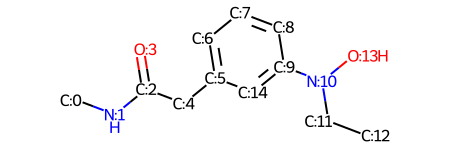

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 14])

In [55]:
def add_immediate_neighbors(mol, indices):
    def _add_neighbors(idx_list):
        atoms = list(map(lambda x: mol.GetAtomWithIdx(int(x)), idx_list))
        neighbors = []
        for atom in atoms:
            neighbors.extend(list(map(lambda x: x.GetIdx(), atom.GetNeighbors())))
        return np.unique(neighbors).tolist()
    
    # first add immediate neighbors
    indices = _add_neighbors(indices)
    
    # if any aromtic atoms in neighbors, add them as well
    repeat = True
    while repeat:
        repeat = False
        for n in set(_add_neighbors(indices)) - set(indices):
            if mol.GetAtomWithIdx(int(n)).GetIsAromatic():
                indices.append(n)
                repeat = True
    
    return np.unique(indices)
    
mol = Chem.MolFromSmiles("CNC(=O)Cc1cccc(N(CC)O)c1")
display(mol_with_atom_index(mol))
add_immediate_neighbors(mol, [0, 1, 2, 3, 4])

In [56]:
def verify_action_applicability(mol, r_indices, cluster_id):
    mol = Chem.Mol(mol)
    rsig = Chem.MolFromSmiles(dataset[dataset["rsig_clusters"]==cluster_id].iloc[0]["rsig"])
    rsub = Chem.MolFromSmiles(dataset[dataset["rsig_clusters"]==cluster_id].iloc[0]["rsub"])
    rcen = dataset[dataset["rsig_clusters"]==cluster_id].iloc[0]["rcen"]
            
        
#     print("\n\n\n")
#     display(mol_with_atom_index(mol))
#     display(rsig)
#     display(rsub)
#     print(r_indices, rcen)
    # Get the correct rsig_match
    rsig_matches = mol.GetSubstructMatches(rsig)
    if not rsig_matches:
        rsig_match = ()
    else:
        for rsig_match in rsig_matches:
            if not (set(rsig_match) - set(r_indices)):
                break
    
#     print(rsig_match)
    
    # Get the correct rsub_match(s)
    temp_rsub_matches = mol.GetSubstructMatches(rsub)
    rsub_matches = []    
    for rsub_match in temp_rsub_matches:
        if not (set(rsub_match) - set(r_indices)):
            rsub_matches.append(rsub_match)
    
#     print(rsub_matches)
    
    # is there is a rsub whose neighbors are in rsig_match, we're good
    result = False
    for rsub_match in rsub_matches:
        # get neighbors
        atoms = list(map(lambda x: mol.GetAtomWithIdx(x), rsub_match))
        neighbors = []
        for atom in atoms:
            neighbors.extend(list(map(lambda x: x.GetIdx(), atom.GetNeighbors())))
        neighbors = np.unique(neighbors)
#         print(rsub_match, neighbors)
        if not set(neighbors) - set(rsig_match):
            result = True
#     print(result)
    return result
    
def get_mol_from_index_list(mol, indices):
    rw = Chem.RWMol(mol)
    rw.BeginBatchEdit()
    for idx in set(list(range(mol.GetNumAtoms()))) - set(indices):
        rw.RemoveAtom(idx)
    rw.CommitBatchEdit()
    return Chem.Mol(rw)
    

### For a new molecule, let's find all possible actions applicable

In mol


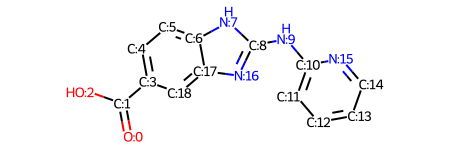

[11599, 106253]
CPU times: user 53 ms, sys: 2 µs, total: 53 ms
Wall time: 51.6 ms


In [114]:
%%time
def get_applicable_rsig_clusters(in_mol):
    # For each cut vertex, we find two disconnected components and search the smaller one in our index
    G = nx.from_numpy_matrix(Chem.GetAdjacencyMatrix(in_mol))
    applicable_actions = []

    for x in nx.articulation_points(G):
        # Remove atom (not directly, otherwise the index resets)
        # First remove bonds to x
        mw = Chem.RWMol(in_mol)
        Chem.Kekulize(mw, clearAromaticFlags=True)
        for n in mw.GetAtomWithIdx(x).GetNeighbors():
            mw.RemoveBond(x, n.GetIdx())

        # Find fragments
        mol_frags = list(Chem.rdmolops.GetMolFrags(mw))

        # Remove x from fragments
        mol_frags.remove((x,))

        # For each fragment except the biggest, add x and extract sub-molecule and search
        for frag in sorted(mol_frags, key=lambda x: len(x))[:-1]:
            indices = [x] + list(frag)

            for _ in range(2):
                # we add neighbors twice to rsub and then search for rsig
                indices = add_immediate_neighbors(in_mol, indices)
                candidate = get_mol_from_index_list(in_mol, indices)
#                 Chem.Kekulize(candidate)
                try:
                    Chem.SanitizeMol(candidate)
                except Exception as e:
                    pass
#                 print(Chem.MolToSmiles(candidate))
#                 display(mol_with_atom_index(candidate))

                # get certificate and search in rsig
                cand_certi = get_mol_certificate(candidate)

                if cand_certi in certificate_to_cluster_id_dict:
                    # Verify rsig
                    for cluster_id in certificate_to_cluster_id_dict[cand_certi]:
    #                     print("Verification...", cluster_id)
                        if verify_action_applicability(in_mol, indices, cluster_id):
                            if cluster_id not in applicable_actions:
                                row = dataset[dataset["rsig_clusters"]==cluster_id].iloc[0]
#                                 print(row)
#                                 display(mol_with_atom_index(Chem.MolFromSmiles(row["reactants"])))
#                                 display(mol_with_atom_index(Chem.MolFromSmiles(row["products"])))
#                                 display(mol_with_atom_index(Chem.MolFromSmiles((row["rsig"]))))
#                                 display(mol_with_atom_index(candidate))
                                applicable_actions.append(cluster_id)
    return applicable_actions
                            

# Get input mol
print("In mol")
i=98
in_mol = Chem.MolFromSmiles(dataset.iloc[i]["reactants"])
display(mol_with_atom_index(in_mol))


print(get_applicable_rsig_clusters(in_mol))

i += 1

In [ ]:
for i in [5040, 8955, 40634, 46, 28355, 353637, 210, 5693, 89155, 312779]:
    row = dataset[dataset["rsig_clusters"]==i].iloc[0]
    print(i)
    display(Chem.MolFromSmiles(row["rsig"]))

In [ ]:
# Some stats for the action searching
count = 0
cluster_count = 0
action_count = 0
time_taken = 0

import time
for i in tqdm.tqdm(range(50000)):
    t = time.time()
    clusters = get_applicable_rsig_clusters(Chem.MolFromSmiles(dataset.iloc[i]["reactants"]))
    cluster_count += len(clusters)
    action_count += len(dataset[dataset["rsig_clusters"].isin(clusters)])
    time_taken += (time.time() - t)
    count += 1
#     break
    
print(f"Avg cluster count = {cluster_count/count}")
print(f"Avg action count = {action_count/count}")
print(f"Avg time taken = {time_taken/count}")

# Applying actions

Input molecule (i = 14444)


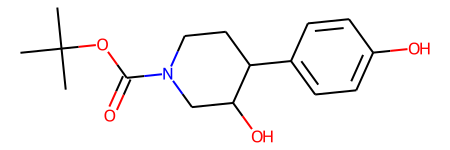

Random rsig chosen (rcen = 0)


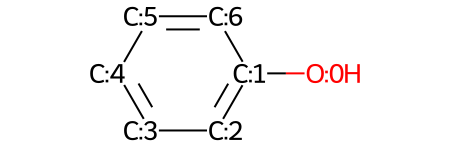

Random psig chosen (pcen = 5)


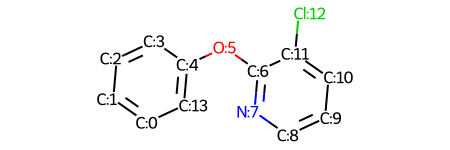

In [116]:
i = np.random.randint(0, 50000)
i = 14444
in_mol = Chem.MolFromSmiles(dataset.iloc[i]["reactants"])

# Pick a random action from all the possible ones
temp_df = dataset[dataset["rsig_clusters"].isin(get_applicable_rsig_clusters(in_mol))]
random_action = temp_df.iloc[int(np.random.random()*temp_df.shape[0])]

print(f"Input molecule (i = {i})")
display(in_mol)
print(f"Random rsig chosen (rcen = {random_action['rcen']})")
display(Chem.MolFromSmiles(random_action["rsig"]))
print(f"Random psig chosen (pcen = {random_action['pcen']})")
display(Chem.MolFromSmiles(random_action["psig"]))

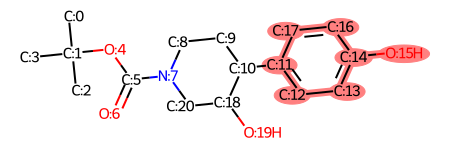

rcen= 0
rsub


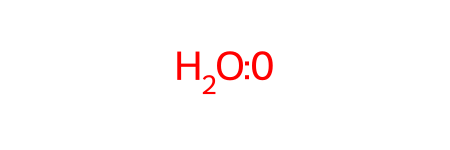

rsig


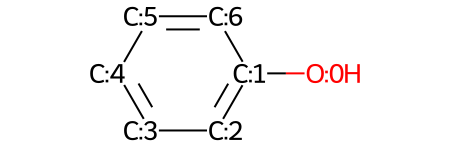

pcen= 5
psub


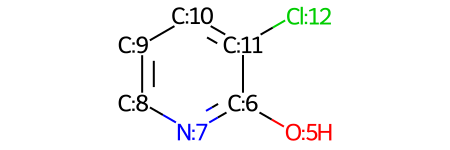

psig


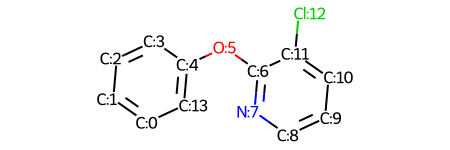

rsig_match (15, 14, 13, 12, 11, 17, 16)
cs


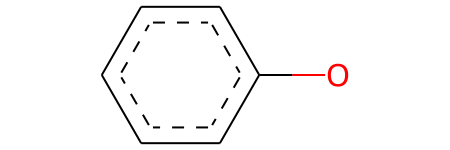

input_mol_cs_indices [15, 14, 13, 12, 11, 17, 16]
psig_cs_indices (5, 4, 3, 2, 1, 0, 13)
rwmol with atom map nums


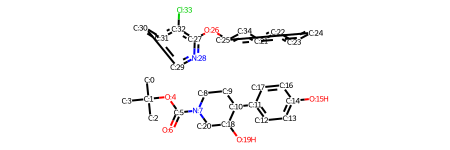

rwmol with indices


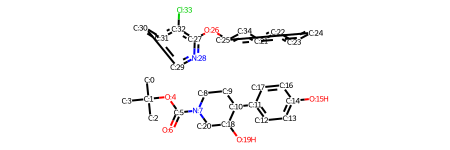

cs indices: [15, 14, 13, 12, 11, 17, 16] (5, 4, 3, 2, 1, 0, 13)
atom map nums: [15, 14, 13, 12, 11, 17, 16] [26, 25, 24, 23, 22, 21, 34]
15 26 15 26
set()
14 25 14 25
set()
13 24 13 24
set()
12 23 12 23
set()
11 22 11 22
{10}
11 22 10


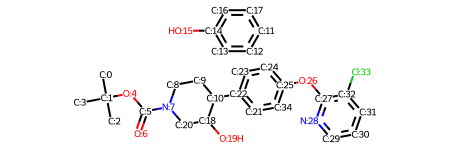

17 21 17 21
set()
16 34 16 34
set()
Final mol


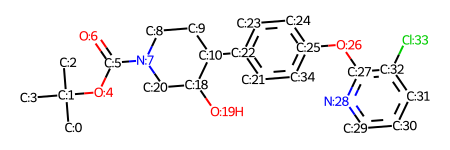

In [118]:
from rdkit.Chem import rdFMCS

def mol_with_atom_index( mol ):
    '''
    draw molecule with index
    '''
    colored = False
    if hasattr(mol, "__sssAtoms"):
        sss = mol.__sssAtoms
        colored = True
    mol = Chem.Mol(mol)
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    if colored:
        mol.__sssAtoms = sss
    return mol

def smiles_without_atom_index( smiles ):
    '''
    Convert smiles with numbers to smiles without numbers
    '''
    mol = Chem.MolFromSmiles(smiles)
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).ClearProp( 'molAtomMapNumber' )
    return Chem.MolToSmiles(mol)

def find_connecting_atoms_not_in_sig(mol, sig_indices, centre):
    cen_atom = mol.GetAtomWithIdx(centre)
    neighbors_indices = list(map(lambda x: x.GetIdx(), cen_atom.GetNeighbors()))
    return set(neighbors_indices) - set(sig_indices)

def GetAtomWithAtomMapNum(mol, num):
    for atom in mol.GetAtoms():
        if atom.GetAtomMapNum() == num:
            return atom
    return None

def apply_action(input_mol, rsub, rcen, rsig, psub, pcen, psig):
    input_mol = Chem.Mol(input_mol)
    rsig = Chem.MolFromSmiles(rsig)
    psig = Chem.MolFromSmiles(psig)
    rsig_matches = input_mol.GetSubstructMatches(rsig)
    display(mol_with_atom_index(input_mol))
    
    print("rcen=",rcen)
    print("rsub")
    display(Chem.MolFromSmiles(rsub))
    print("rsig")
    display(rsig)
    print("pcen=", pcen)
    print("psub")
    display(Chem.MolFromSmiles(psub))
    print("psig")
    display(psig)
    
    # FIXME: Provide option to use more than just the first match
    rsig_match = rsig_matches[0]
    print("rsig_match", rsig_match)

    # Replace rsig with psig
    mcs = rdFMCS.FindMCS([rsig, psig])
    cs = Chem.MolFromSmarts(mcs.smartsString)
    print("cs")
    display(cs)
    input_mol_cs_indices = np.array(rsig_match)[list(Chem.Mol(rsig).GetSubstructMatch(cs))].tolist()
    psig_cs_indices = Chem.Mol(psig).GetSubstructMatch(cs)
    print("input_mol_cs_indices", input_mol_cs_indices)
    print("psig_cs_indices", psig_cs_indices)
    
    rwmol = Chem.RWMol(mol_with_atom_index(input_mol))
    num_atoms = input_mol.GetNumAtoms()
    new_psig = Chem.Mol(psig)
    for atom in new_psig.GetAtoms():
        atom.SetAtomMapNum(atom.GetAtomMapNum() + num_atoms)
    rwmol.InsertMol(Chem.Mol(new_psig))
    print("rwmol with atom map nums")
    display(rwmol)
    print("rwmol with indices")
    display(rwmol)
    print("cs indices:", input_mol_cs_indices, psig_cs_indices)
    
    # TODO: FIND A BETTER WAY TO FIND THE INDICES OF THE TWO CONNECTED COMPONENTS
    rsig_cs_atom_map_num = list(input_mol_cs_indices)
    psig_cs_atom_map_num = (np.array(psig_cs_indices)+num_atoms).tolist()
    
    print("atom map nums:", rsig_cs_atom_map_num, psig_cs_atom_map_num)
    for r_an, p_an in zip(rsig_cs_atom_map_num, psig_cs_atom_map_num):
        r_idx = GetAtomWithAtomMapNum(rwmol, r_an).GetIdx()
        p_idx = GetAtomWithAtomMapNum(rwmol, p_an).GetIdx()
        print(r_an, p_an, r_idx, p_idx)
        print(find_connecting_atoms_not_in_sig(in_mol, rsig_match, r_idx))
        for conn in find_connecting_atoms_not_in_sig(in_mol, rsig_match, r_idx):
            print(r_idx, p_idx, conn)
            rwmol.AddBond(p_idx, conn, input_mol.GetBondBetweenAtoms(r_idx, conn).GetBondType())
            rwmol.RemoveBond(r_idx, conn)
            display(rwmol)
            
    # TODO: FIND A BETTER WAY TO REMOVE THE DISCONNECTED MOLECULE
#     mol = Chem.Mol(rwmol)
#     print(mol)
#     mol = Chem.MolToSmiles(mol)
#     print(mol)
#     mol = mol.split(".")
#     mol = max(mol, key=len)
#     print(mol)
#     mol = Chem.MolFromSmiles(mol)
#     print(mol)
    for atm_num in rsig_match:
        rwmol.RemoveAtom(GetAtomWithAtomMapNum(rwmol, atm_num).GetIdx())
    
    mol = Chem.Mol(rwmol)
    print("Final mol")
    display(mol)
    return mol


#     # Find the connecting atom idx
#     connecting_atoms = []
#     for atm_idx in rsig_match:
#         atom = input_mol.GetAtomWithIdx(atm_idx)
#         neighbors = atom.GetNeighbors()

#         neighbors_indices = list(map(lambda x: x.GetIdx(), neighbors))
#         connecting_atoms.extend(list(map(lambda x: input_mol.GetAtomWithIdx(x), set(neighbors_indices) - set(rsig_match))))
#     print(connecting_atoms)
#     pcen_atom = input_mol.GetAtomWithIdx(int(pcen))
        
#     print("Input molecule with canditate matches")
#     display(mol_with_atom_index(input_mol))
#     rwmol = Chem.RWMol(input_mol)
#     for idx in rsig_match:
#         rwmol.RemoveAtom(idx)
#     print("Input molecule without rsig")
#     display(mol_witcsh_atom_index(rwmol))

#     original_num_atoms = rwmol.GetNumAtoms()
#     rwmol.InsertMol(Chem.MolFromSmiles(smiles_without_atom_index(psig)))
# #     display(mol_with_atom_index(rwmol))
    
#     for c_atom in connecting_atoms:
# #         print(c_atom.GetIdx(), pcen_atom.GetIdx()+original_num_atoms)
#         rwmol.AddBond(c_atom.GetIdx(), pcen_atom.GetIdx()+original_num_atoms, Chem.BondType.SINGLE)
    
#     output_mol = Chem.Mol(rwmol)
    
#     temp_mol = Chem.Mol(output_mol)
#     temp_mol.GetSubstructMatch(Chem.MolFromSmiles(psig))
#     print("Input molecule with psig")
#     display(mol_with_atom_index(temp_mol))
#     display(Chem.MolFromSmiles(psig))
#     print(pcen)
    
#     return output_mol
    
apply_action(in_mol, random_action["rsub"], random_action["rcen"], random_action["rsig"], random_action["psub"], random_action["pcen"], random_action["psig"])
pass

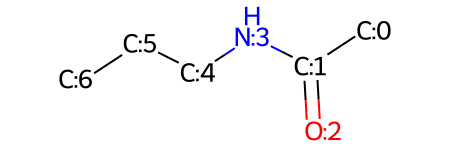

In [83]:
mol = mol_with_atom_index(Chem.MolFromSmiles("CC(=O)NCCC"))
display(mol)

In [88]:
a = mol.GetAtomWithIdx(3)

a.GetAtomMapNum()

3

In [93]:
GetAtomWithAtomMapNum(mol, 9)